# UK Online Retail – Repeat Purchase / Retention Analysis

**Goal:** engineer customer-level behavioural features from transaction history and predict whether a customer repeats a purchase in a future label window.

This notebook is organised in a standard analysis flow: setup → data prep → feature engineering → EDA → clustering → modelling → results.

## Contents
1. Setup
2. Load data
3. Data preparation and cleaning
4. Build a transaction-level dataset
5. Define feature and target windows
6. Customer-level feature engineering
7. Basket and time-series EDA
8. Exploratory analysis of engineered customer features
9. Clustering
10. Modelling and evaluation


## 1. Setup

Import libraries and set global configuration.

In [1]:
# Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_fscore_support
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
pd.set_option("display.max_columns", 100)
    

## 2. Load data

Read the raw dataset from disk.

In [2]:
df_raw = pd.read_csv("UK_online_retail.csv", encoding="ISO-8859-1")
df_raw.head()



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 3. Data preparation and cleaning

Load the dataset, check missingness, and apply basic cleaning rules (remove missing CustomerID, refunds/cancellations, and invalid prices).

CustomerID     0.271321
Description    0.001217
InvoiceNo      0.000000
Quantity       0.000000
StockCode      0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
Country        0.000000
TotalPrice     0.000000
dtype: float64

Average TotalPrice by CustomerID missingness:
CustomerID
Non-missing CustomerID    20.625073
Missing CustomerID        13.012305
Name: TotalPrice, dtype: float64


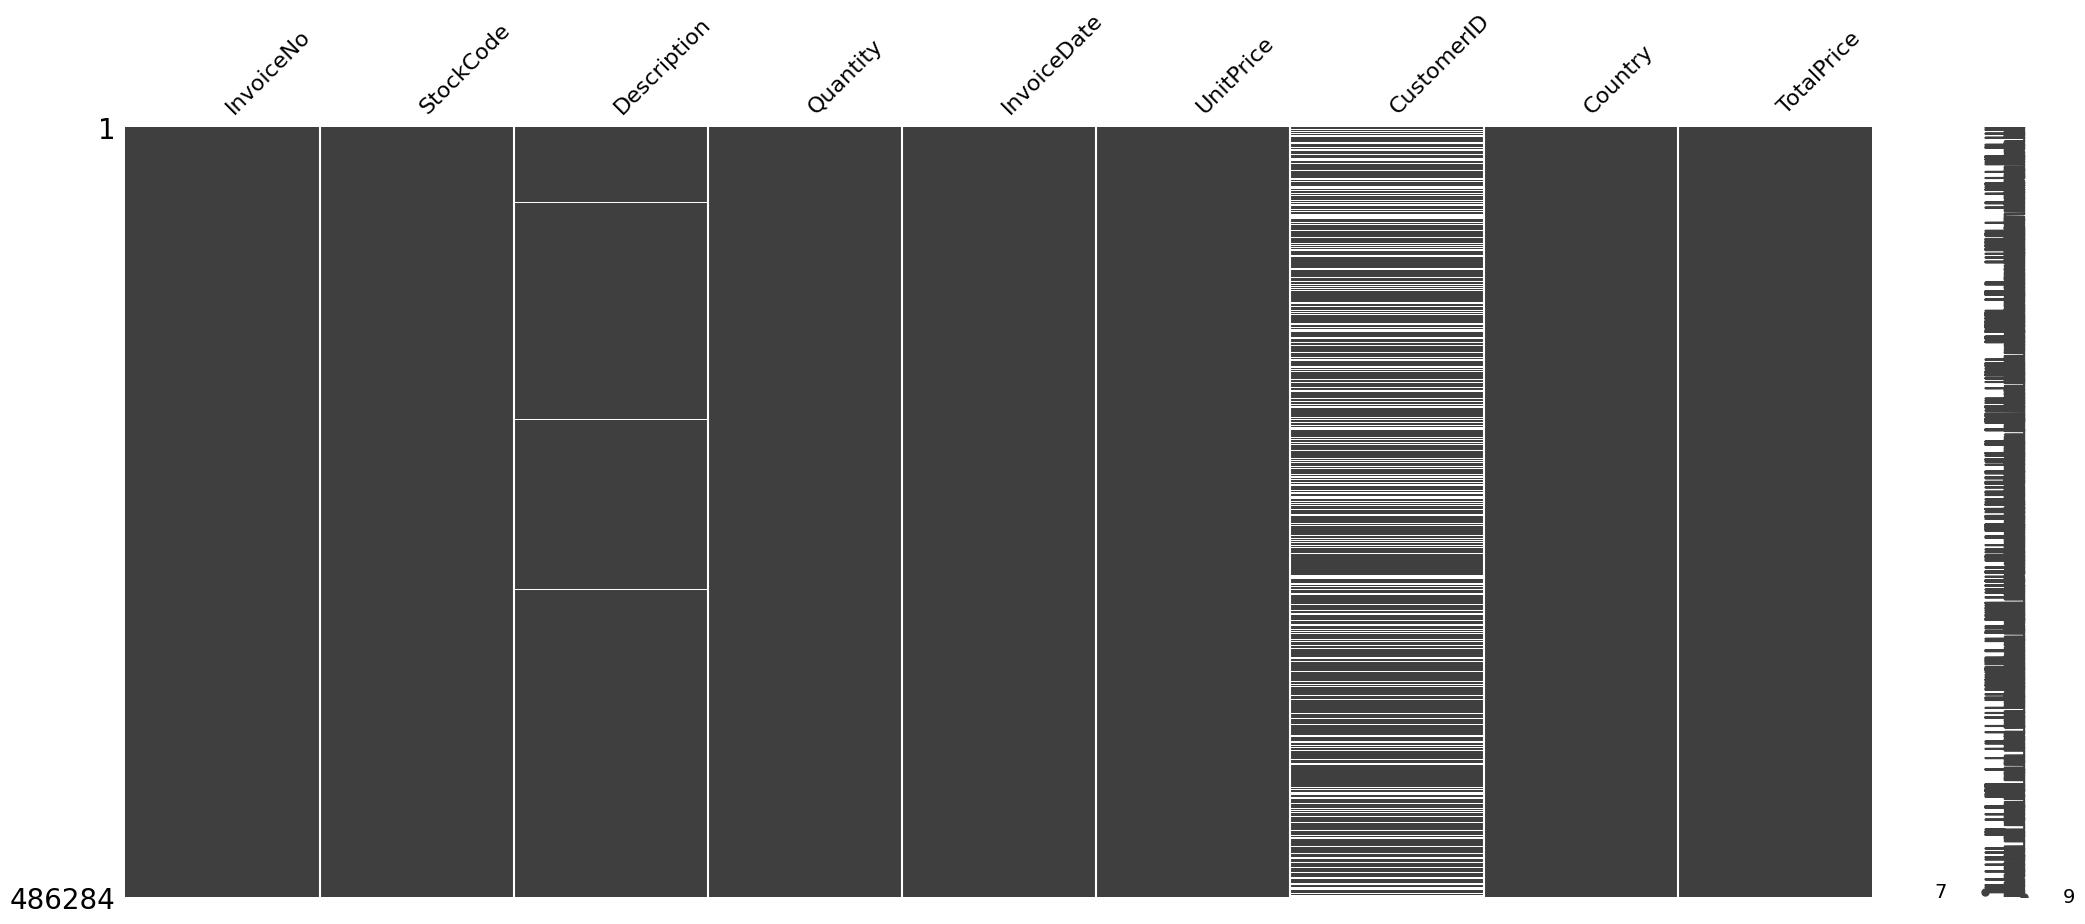

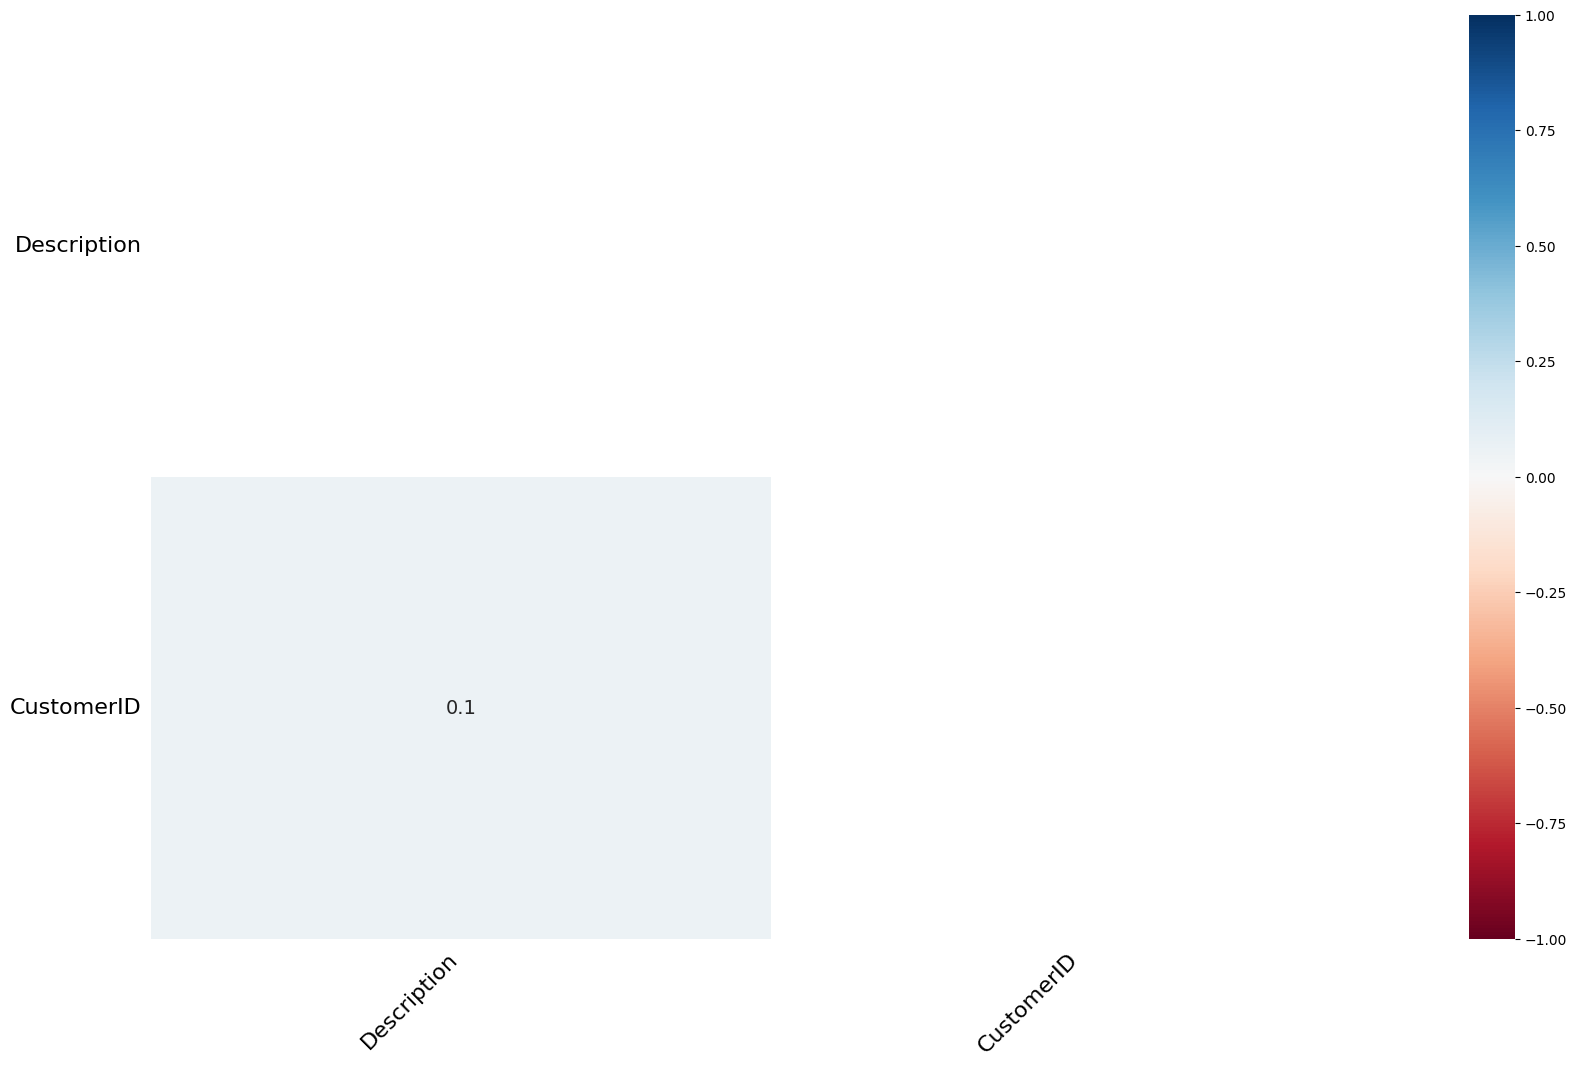

In [3]:
# Copy raw data
df = df_raw.copy()

# Compute row-level revenue
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# Summarize missing values
print(
    df.isna()
      .mean()
      .sort_values(ascending=False)
)

# Plot missing values
import missingno as msno

msno.matrix(df)
msno.heatmap(df)

# Compare spend for missing CustomerID rows
missing_custid_spend = (
    df.groupby(df["CustomerID"].isna())["TotalPrice"]
      .mean()
      .rename(index={True: "Missing CustomerID", False: "Non-missing CustomerID"})
)

print("\nAverage TotalPrice by CustomerID missingness:")
print(missing_custid_spend)


In [4]:
df_raw.isna().sum().sort_values(ascending=False)
df_raw.isna().mean().sort_values(ascending=False).head(10)  # Proportion

df_raw["Description"] = df_raw["Description"].fillna("Missing_Description")
df_raw.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df = df_raw.copy()

# Convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Drop rows with missing CustomerID
df = df[~df["CustomerID"].isna()]

# Drop non-positive quantities
df = df[df["Quantity"] > 0]

# Drop non-positive prices
df = df[df["UnitPrice"] > 0]
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# IQR-based outlier detection for TotalPrice
Q1 = df["TotalPrice"].quantile(0.25)
Q3 = df["TotalPrice"].quantile(0.75)
IQR = Q3 - Q1
  
df["Outlier_TotalPrice"] = (
    (df["TotalPrice"] < Q1 - 1.5*IQR) |
    (df["TotalPrice"] > Q3 + 1.5*IQR)
)

df["Outlier_TotalPrice"].mean()


# Ensure CustomerID is integer
df["CustomerID"] = df["CustomerID"].astype(int)


# Verify cleaned data
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
Index: 354321 entries, 0 to 486283
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   InvoiceNo           354321 non-null  object        
 1   StockCode           354321 non-null  object        
 2   Description         354321 non-null  object        
 3   Quantity            354321 non-null  int64         
 4   InvoiceDate         354321 non-null  datetime64[ns]
 5   UnitPrice           354321 non-null  float64       
 6   CustomerID          354321 non-null  int64         
 7   Country             354321 non-null  object        
 8   TotalPrice          354321 non-null  float64       
 9   Outlier_TotalPrice  354321 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 27.4+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Outlier_TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,False
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,False


## 4. Build a transaction-level dataset

Aggregate line items into invoice-level transactions. This produces one row per invoice per customer per day, which we use for feature engineering and downstream analysis.

In [6]:
# Create a transaction date only field
df["InvoiceDateOnly"] = df["InvoiceDate"].dt.date

# Transaction-level aggregation
txn = (
    df.groupby(["InvoiceNo", "CustomerID", "InvoiceDateOnly"], as_index=False)
      .agg(
          Quantity=("Quantity", "sum"),
          BasketValue=("TotalPrice", "sum"),
          UnitPrice=("UnitPrice", "mean")
      )
)


txn.head()



,InvoiceNo,CustomerID,InvoiceDateOnly,Quantity,BasketValue,UnitPrice
0,536365,17850,2010-12-01,40,139.12,3.910000
1,536366,17850,2010-12-01,12,22.20,1.850000
2,536367,13047,2010-12-01,83,278.73,4.853333
3,536368,13047,2010-12-01,15,70.05,4.775000
4,536369,13047,2010-12-01,3,17.85,5.950000


In [7]:
# Simple univariate outlier check using IQR
def iqr_outlier_bounds(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return lower, upper

for col in ["BasketValue"]:
    low, high = iqr_outlier_bounds(txn[col])
    print(col, "bounds:", low, high)
    print("Outlier %:", ((txn[col] < low) | (txn[col] > high)).mean())

low, high = iqr_outlier_bounds(txn["BasketValue"])
txn["BasketValue_clipped"] = txn["BasketValue"].clip(lower=low, upper=high)




BasketValue bounds: -284.09999999999997 881.46
Outlier %: 0.07424315233061028


## 5. Define feature and target windows

Split the timeline into:

- **Feature window**: historical period used to compute customer behaviour features.
- **Target (label) window**: future period used to define the repeat-purchase outcome.

This reduces leakage by ensuring features are computed only from past data.

In [8]:
# ---
# Script-A style feature/label split
# ---

LABEL_MONTHS = 3
WIN_PCT = 0.95  # Winsorization threshold

# Ensure InvoiceDateOnly is datetime
txn["InvoiceDateOnly"] = pd.to_datetime(txn["InvoiceDateOnly"])

dataset_min = txn["InvoiceDateOnly"].min()
dataset_max = txn["InvoiceDateOnly"].max()

label_end = dataset_max
label_start = label_end - pd.DateOffset(months=LABEL_MONTHS) + pd.Timedelta(days=1)
feature_end = label_start - pd.Timedelta(days=1)

feature_txn = txn[txn["InvoiceDateOnly"] <= feature_end].copy()
target_txn  = txn[txn["InvoiceDateOnly"] >= label_start].copy()

print("===== Date Ranges for Splits =====")
print(f"Dataset range: {dataset_min.date()} to {dataset_max.date()}")
print(f"Historical feature period: {dataset_min.date()} to {feature_end.date()}")
print(f"Label period (prediction target): {label_start.date()} to {label_end.date()}")
print("=================================")

# Guardrail: no overlap
assert feature_txn["InvoiceDateOnly"].max() <= feature_end
assert target_txn["InvoiceDateOnly"].min() >= label_start

feature_txn.head(), target_txn.head()


===== Date Ranges for Splits =====
Dataset range: 2010-12-01 to 2011-12-09
Historical feature period: 2010-12-01 to 2011-09-09
Label period (prediction target): 2011-09-10 to 2011-12-09


(  InvoiceNo  CustomerID InvoiceDateOnly  Quantity  BasketValue  UnitPrice  \
 0    536365       17850      2010-12-01        40       139.12   3.910000   
 1    536366       17850      2010-12-01        12        22.20   1.850000   
 2    536367       13047      2010-12-01        83       278.73   4.853333   
 3    536368       13047      2010-12-01        15        70.05   4.775000   
 4    536369       13047      2010-12-01         3        17.85   5.950000   
 
    BasketValue_clipped  
 0               139.12  
 1                22.20  
 2               278.73  
 3                70.05  
 4                17.85  ,
      InvoiceNo  CustomerID InvoiceDateOnly  Quantity  BasketValue  UnitPrice  \
 9382    568781       14952      2011-09-29       436      1115.64   3.705714   
 9383    568782       13985      2011-09-29       494      1018.22   2.425000   
 9384    568783       17739      2011-09-29       120       542.16   5.382500   
 9385    568784       15144      2011-09-29      

Text(0.5, 1.0, 'Temporal Stability Check: Feature vs Target Window')

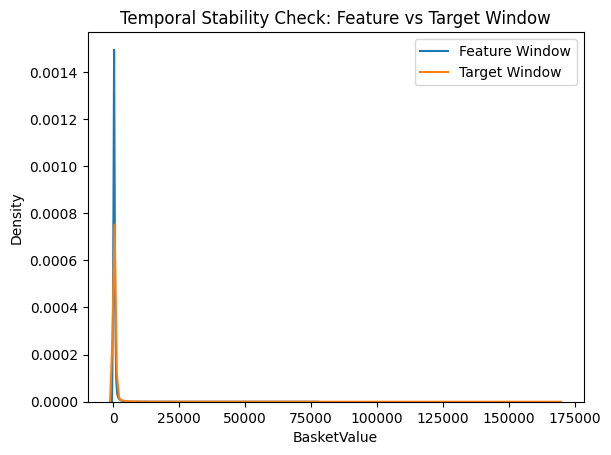

In [9]:
# Compare price distributions across windows to check for leakage / structural breaks
sns.kdeplot(feature_txn["BasketValue"], label="Feature Window")
sns.kdeplot(target_txn["BasketValue"], label="Target Window")
plt.legend()
plt.title("Temporal Stability Check: Feature vs Target Window")


## 6. Customer-level feature engineering

Aggregate transactions in the **feature window** into customer-level behavioural features and create the repeat-purchase target label.

In [10]:
# ---
# Customer-level features
# ---

# Aggregate customer history from FEATURE window only
cust_features = (
    feature_txn
    .groupby("CustomerID")
    .agg(
        Frequency=("InvoiceNo", "nunique"),
        Monetary_sum=("BasketValue", "sum"),
        Monetary_avg=("BasketValue", "mean"),
        LastPurchaseDate=("InvoiceDateOnly", "max")
    )
    .reset_index()
)

cust_features["LastPurchaseDate"] = pd.to_datetime(cust_features["LastPurchaseDate"])

# Recency measured to feature_end
cust_features["Recency"] = (pd.to_datetime(feature_end) - cust_features["LastPurchaseDate"]).dt.days.clip(lower=0)

# Drop helper
cust_features = cust_features.drop(columns=["LastPurchaseDate"])

# Ensure ALL customers are included
all_customers = pd.DataFrame({"CustomerID": txn["CustomerID"].unique()})
cust_features = all_customers.merge(cust_features, on="CustomerID", how="left")

# Fill missing defaults
default_recency = (pd.to_datetime(feature_end) - pd.to_datetime(dataset_min)).days + 1
cust_features[["Recency", "Frequency", "Monetary_sum", "Monetary_avg"]] = cust_features[
    ["Recency", "Frequency", "Monetary_sum", "Monetary_avg"]
].fillna({
    "Recency": default_recency,
    "Frequency": 0,
    "Monetary_sum": 0,
    "Monetary_avg": 0
})

cust_features.head()


,CustomerID,Frequency,Monetary_sum,Monetary_avg,Recency
0,17850,34.0,5391.21,158.56500,281.0
1,13047,8.0,2682.01,335.25125,36.0
2,13748,5.0,948.25,189.65000,4.0
3,15100,3.0,876.00,292.00000,242.0
4,15291,12.0,3685.02,307.08500,3.0


In [11]:
from scipy.stats import skew, kurtosis, yeojohnson

for col in ["Frequency", "Monetary_sum", "Monetary_avg", "Recency"]:
    print(col, "Skew:", skew(cust_features[col]), "Kurtosis:", kurtosis(cust_features[col]))

# Apply Yeo-Johnson transform to correct skewness
cust_features["Monetary_YJ"], lam_m = yeojohnson(cust_features["Monetary_sum"])
cust_features["Frequency_YJ"], lam_f = yeojohnson(cust_features["Frequency"])


Frequency Skew: 9.112821824827721 Kurtosis: 151.31711451782508
Monetary_sum Skew: 16.196074377358986 Kurtosis: 374.8408184303575
Monetary_avg Skew: 53.10237253241834 Kurtosis: 3098.5666447588483
Recency Skew: 0.2656857347362649 Kurtosis: -1.4936833871343258


In [12]:
# Creating target variable
# Customers who bought in target window
repeat_customers = target_txn["CustomerID"].unique()
cust_features["RepeatCustomer"] = cust_features["CustomerID"].isin(repeat_customers).astype(int)

cust_features["RepeatCustomer"].value_counts(normalize=True)


RepeatCustomer
1    0.666582
0    0.333418
Name: proportion, dtype: float64

In [13]:
# Interaction data
cust_features["AvgOrderValue"] = np.where(
    cust_features["Frequency"] > 0,
    cust_features["Monetary_sum"] / cust_features["Frequency"],
    0
)

cust_features["RecencyFrequencyRatio"] = np.where(
    cust_features["Frequency"] > 0,
    cust_features["Recency"] / cust_features["Frequency"],
    0
)

In [ ]:
# Behavioural stability features

# Ensure proper dtypes
feature_txn["InvoiceDateOnly"] = pd.to_datetime(feature_txn["InvoiceDateOnly"])


# Use end of feature window as snapshot
snapshot = pd.to_datetime(feature_end) + pd.Timedelta(days=1)

# A) Orders in last 30/60/90 days
def orders_last_n_days(n: int) -> pd.Series:
    cutoff = snapshot - pd.Timedelta(days=n)
    return (
        feature_txn.loc[feature_txn["InvoiceDateOnly"] >= cutoff]
        .groupby("CustomerID")["InvoiceNo"]
        .nunique()
        .rename(f"Orders_{n}d")
    )

orders_30 = orders_last_n_days(30)
orders_60 = orders_last_n_days(60)
orders_90 = orders_last_n_days(90)

orders_windows = pd.concat([orders_30, orders_60, orders_90], axis=1).reset_index()


# B) Time to second purchase
# Work at unique purchase-date level
cust_dates = (
    feature_txn[["CustomerID", "InvoiceDateOnly"]]
    .drop_duplicates()
    .sort_values(["CustomerID", "InvoiceDateOnly"])
)

# Get 1st and 2nd purchase dates per customer
first_second = (
    cust_dates
    .groupby("CustomerID")["InvoiceDateOnly"]
    .apply(lambda s: pd.Series([s.iloc[0], s.iloc[1]] if len(s) >= 2 else [s.iloc[0], pd.NaT]))
)
first_second = first_second.unstack()
first_second.columns = ["FirstPurchaseDate", "SecondPurchaseDate"]

time_to_second = (
    (first_second["SecondPurchaseDate"] - first_second["FirstPurchaseDate"])
    .dt.days
    .rename("TimeToSecondPurchase")
    .reset_index()
)

# Customers who never made a 2nd purchase in the feature window:
# Keep as 999
time_to_second["TimeToSecondPurchase"] = time_to_second["TimeToSecondPurchase"].fillna(999)


# C) Purchase acceleration
# Define acceleration as:
# Positive => gaps shrinking => accelerating purchases
def purchase_acceleration(dates: pd.Series) -> float:
    dates = dates.sort_values()
    if len(dates) < 3:
        return 0.0
    gaps = dates.diff().dt.days.dropna()
    if len(gaps) < 2:
        return 0.0
    return float(gaps.iloc[-2] - gaps.iloc[-1])

accel = (
    cust_dates
    .groupby("CustomerID")["InvoiceDateOnly"]
    .apply(purchase_acceleration)
    .rename("PurchaseAcceleration")
    .reset_index()
)

# 1) Purchase gaps
gaps = (
    feature_txn.sort_values(["CustomerID", "InvoiceDateOnly"])
    .groupby("CustomerID")["InvoiceDateOnly"]
    .diff()
    .dt.days
)

gap_stats = (
    pd.DataFrame({"CustomerID": feature_txn["CustomerID"], "GapDays": gaps})
    .dropna(subset=["GapDays"])
    .groupby("CustomerID")["GapDays"]
    .agg(MeanGap="mean", StdGap="std")
    .reset_index()
)

# 2) Basket variability
basket_stats = (
    feature_txn.groupby("CustomerID")["BasketValue_clipped"]
    .agg(_mean="mean", _std="std")
    .reset_index()
)
basket_stats["BasketCV"] = np.where(
    basket_stats["_mean"] > 0,
    basket_stats["_std"] / basket_stats["_mean"],
    0
)
basket_stats = basket_stats[["CustomerID", "BasketCV"]]

# 3) Spend trend over time
monthly = feature_txn.copy()
monthly["YearMonth"] = monthly["InvoiceDateOnly"].dt.to_period("M").astype(str)
monthly = (
    monthly.groupby(["CustomerID", "YearMonth"])["BasketValue_clipped"]
    .sum()
    .reset_index(name="MonthlySpend")
)

def _trend_slope(grp):
    # Slope of spend over time index
    if len(grp) < 2:
        return 0.0
    y = grp["MonthlySpend"].to_numpy(dtype=float)
    x = np.arange(len(y), dtype=float)
    return float(np.polyfit(x, y, 1)[0])

spend_trend = (
    monthly.sort_values(["CustomerID", "YearMonth"])
    .groupby("CustomerID", as_index=False)
    .apply(_trend_slope)
    .rename(columns={None: "SpendTrend"})
)

# Merge into cust_features
cust_features = cust_features.merge(gap_stats, on="CustomerID", how="left")
cust_features = cust_features.merge(basket_stats, on="CustomerID", how="left")
cust_features = cust_features.merge(spend_trend, on="CustomerID", how="left")
cust_features = cust_features.merge(orders_windows, on="CustomerID", how="left")
cust_features = cust_features.merge(time_to_second, on="CustomerID", how="left")
cust_features = cust_features.merge(accel, on="CustomerID", how="left")


# Fill missing for customers with 0/1 purchases in feature window
cust_features[["MeanGap", "StdGap", "BasketCV", "SpendTrend"]] = cust_features[
    ["MeanGap", "StdGap", "BasketCV", "SpendTrend"]
].fillna(0)

cust_features[["Orders_30d", "Orders_60d", "Orders_90d"]] = cust_features[
    ["Orders_30d", "Orders_60d", "Orders_90d"]
].fillna(0)

# TimeToSecondPurchase already filled with 999 above, but keep safe:
cust_features["TimeToSecondPurchase"] = cust_features["TimeToSecondPurchase"].fillna(999)

cust_features["PurchaseAcceleration"] = cust_features["PurchaseAcceleration"].fillna(0)


cust_features[["Frequency", "MeanGap", "StdGap", "BasketCV", "SpendTrend", "Orders_30d", "Orders_60d", "Orders_90d", "TimeToSecondPurchase", "PurchaseAcceleration"]].describe().T


,count,mean,std,min,25%,50%,75%,max
Frequency,3920.0,2.733673,5.138996,0.00,1.000000e+00,1.0,3.000000,132.000000
MeanGap,3920.0,27.626448,43.654854,0.00,0.000000e+00,0.0,43.062500,271.000000
StdGap,3920.0,9.962614,20.763652,0.00,0.000000e+00,0.0,12.093879,178.190909
BasketCV,3920.0,0.202960,0.296461,0.00,0.000000e+00,0.0,0.371554,1.958704
SpendTrend,3920.0,-11.375867,122.663786,-993.23,-1.478119e-15,0.0,0.000000,2771.820000
Orders_30d,3920.0,0.302806,0.746783,0.00,0.000000e+00,0.0,0.000000,12.000000
Orders_60d,3920.0,0.607143,1.298025,0.00,0.000000e+00,0.0,1.000000,23.000000
Orders_90d,3920.0,0.905867,1.835981,0.00,0.000000e+00,0.0,1.000000,40.000000
TimeToSecondPurchase,3920.0,578.727041,465.866347,1.00,5.900000e+01,999.0,999.000000,999.000000
PurchaseAcceleration,3920.0,-0.375000,28.544887,-199.00,0.000000e+00,0.0,0.000000,244.000000


In [15]:
# ---
# Winsorisation
# ---

# Choose which numeric columns to winsorise
winsor_cols = [
    "Recency", "Frequency", "Monetary_sum", "Monetary_avg",
    "AvgOrderValue", "RecencyFrequencyRatio",
    "MeanGap", "StdGap", "BasketCV", "SpendTrend",
    "Orders_30d", "Orders_60d", "Orders_90d",
    "TimeToSecondPurchase", "PurchaseAcceleration"
]
winsor_cols = [c for c in winsor_cols if c in cust_features.columns]

for col in winsor_cols:
    upper = cust_features[col].quantile(WIN_PCT)
    cust_features[col] = np.where(cust_features[col] > upper, upper, cust_features[col])

cust_features[winsor_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,3920.0,136.987755,105.639082,0.00,3.700000e+01,112.500000,275.000000,283.000000
Frequency,3920.0,2.268112,2.492408,0.00,1.000000e+00,1.000000,3.000000,9.000000
Monetary_sum,3920.0,748.212563,995.691495,0.00,8.314750e+01,334.215000,948.332500,3718.231000
Monetary_avg,3920.0,236.873812,206.041579,0.00,7.041750e+01,203.193333,347.613750,740.576731
AvgOrderValue,3920.0,236.873812,206.041579,0.00,7.041750e+01,203.193333,347.613750,740.576731
RecencyFrequencyRatio,3920.0,53.879022,73.615153,0.00,2.000000e-01,15.000000,82.000000,235.150000
MeanGap,3920.0,25.376167,36.305003,0.00,0.000000e+00,0.000000,43.062500,118.025000
StdGap,3920.0,8.664200,15.866638,0.00,0.000000e+00,0.000000,12.093879,53.575943
BasketCV,3920.0,0.192591,0.266241,0.00,0.000000e+00,0.000000,0.371554,0.818184
SpendTrend,3920.0,-18.638241,97.582139,-993.23,-1.478119e-15,0.000000,0.000000,106.986500


## 7. Basket and time-series EDA

Explore basket-level spend distribution and revenue concentration, then analyse revenue over time (decomposition, seasonality, outliers, volatility).

Basket size (items) and spend summary:


,NumItems,BasketValue
count,16648.000000,16648.000000
mean,255.690774,438.995168
std,947.131847,1663.337209
min,1.000000,0.380000
25%,72.000000,152.985000
50%,150.000000,299.635000
75%,278.000000,444.375000
90%,484.000000,758.486000
95%,719.300000,1090.864000
99%,1874.120000,3114.777400


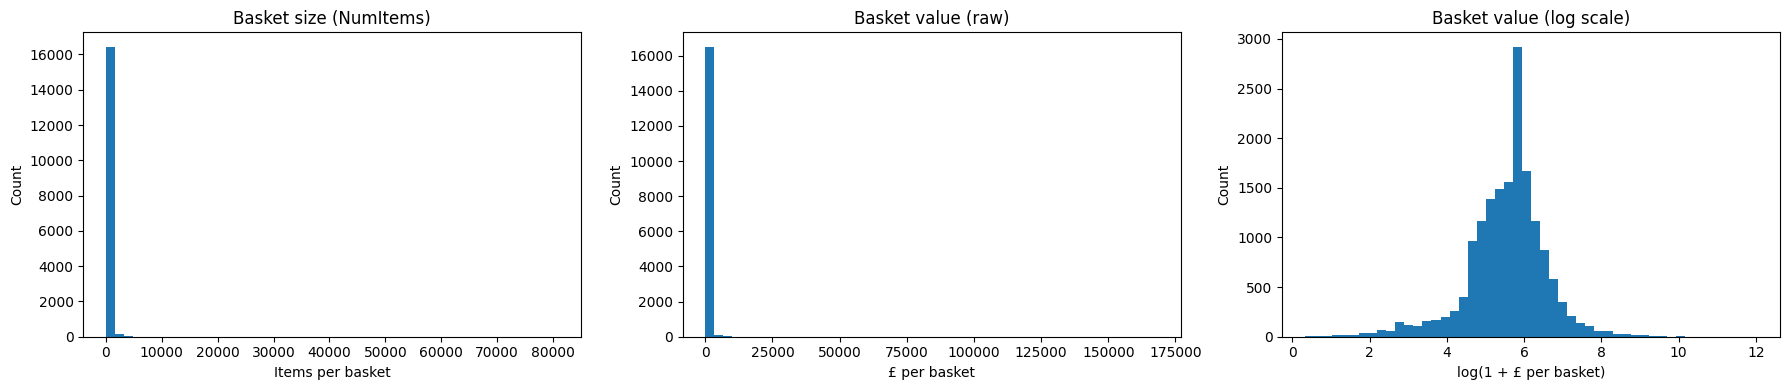

In [16]:
# Basket-level table
basket = (
    df
    .groupby('InvoiceNo')
    .agg(
        BasketDate=('InvoiceDate', 'min'),
        CustomerID=('CustomerID', 'first'),
        NumItems=('Quantity', 'sum'),
        NumLines=('StockCode', 'nunique'),
        BasketValue=('TotalPrice', 'sum')
    )
    .reset_index()
)

# For heavy-tail inspection
basket['BasketValue_log'] = np.log1p(basket['BasketValue'])

# Descriptive stats on basket size / spend
print("Basket size (items) and spend summary:")
display(
    basket[['NumItems', 'BasketValue']].describe(
        percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
    )
)

# Histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].hist(basket['NumItems'], bins=50)
axes[0].set_title('Basket size (NumItems)')
axes[0].set_xlabel('Items per basket')
axes[0].set_ylabel('Count')

axes[1].hist(basket['BasketValue'], bins=50)
axes[1].set_title('Basket value (raw)')
axes[1].set_xlabel('£ per basket')
axes[1].set_ylabel('Count')

axes[2].hist(basket['BasketValue_log'], bins=50)
axes[2].set_title('Basket value (log scale)')
axes[2].set_xlabel('log(1 + £ per basket)')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()


Top 1% of baskets account for 17.7% of total revenue
Top 5% of baskets account for 32.9% of total revenue
Top 10% of baskets account for 43.0% of total revenue
Top 50% of baskets account for 82.5% of total revenue


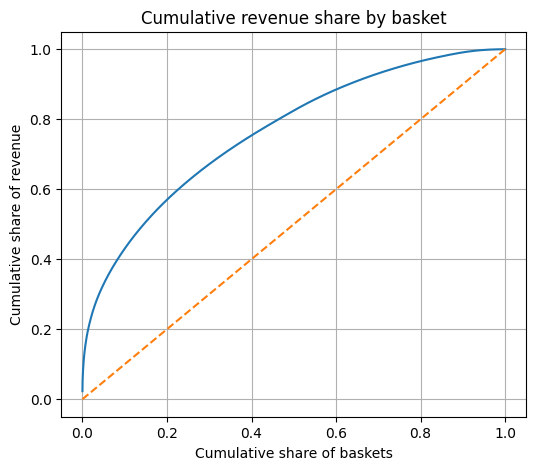

In [17]:
# Sort baskets by value
basket_sorted = basket.sort_values('BasketValue', ascending=False).reset_index(drop=True)

# Cumulative shares
basket_sorted['CumRevenueShare'] = basket_sorted['BasketValue'].cumsum() / basket_sorted['BasketValue'].sum()
basket_sorted['CumBasketShare'] = (np.arange(1, len(basket_sorted) + 1)) / len(basket_sorted)

# Share of revenue from top x% baskets
def revenue_share(top_pct):
    n = int(len(basket_sorted) * top_pct)
    return basket_sorted.loc[:n-1, 'BasketValue'].sum() / basket_sorted['BasketValue'].sum()

for p in [0.01, 0.05, 0.10, 0.50]:
    print(f"Top {int(p*100)}% of baskets account for {revenue_share(p):.1%} of total revenue")

# Lorenz-style curve
plt.figure(figsize=(6, 5))
plt.plot(basket_sorted['CumBasketShare'], basket_sorted['CumRevenueShare'])
plt.plot([0, 1], [0, 1], linestyle='--')  # Equality line
plt.title('Cumulative revenue share by basket')
plt.xlabel('Cumulative share of baskets')
plt.ylabel('Cumulative share of revenue')
plt.grid(True)
plt.show()


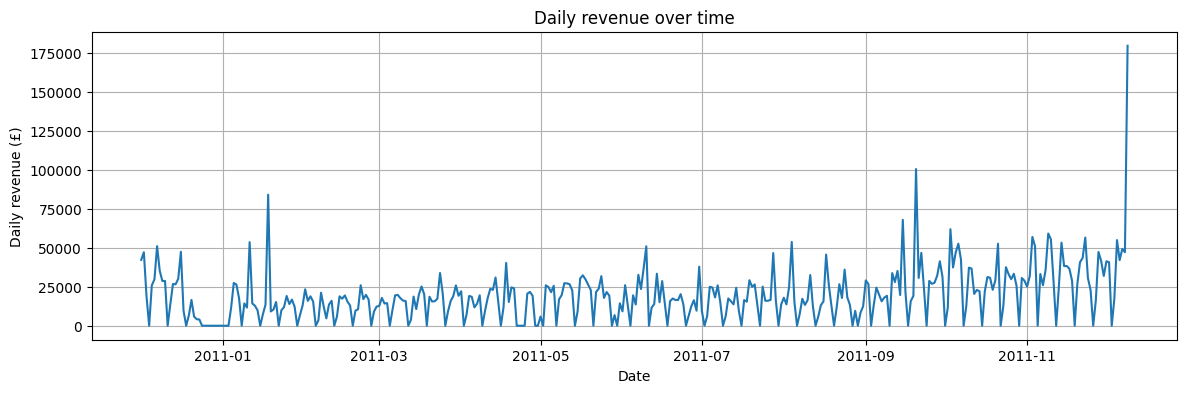

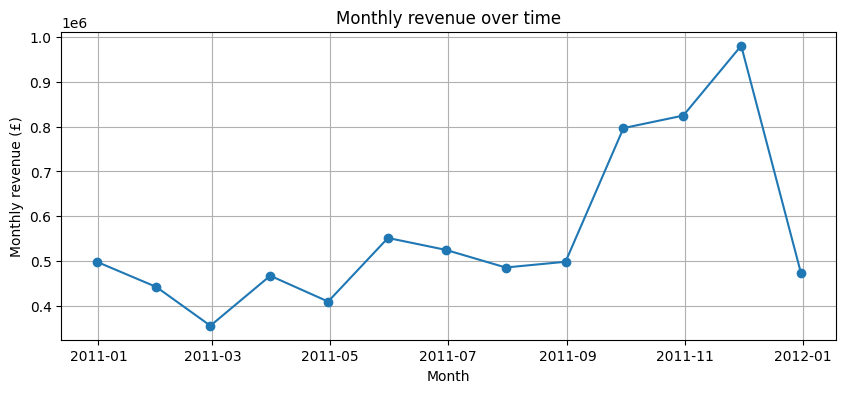

In [18]:
# Daily revenue time series
daily_rev = (
    df
    .groupby(df['InvoiceDate'].dt.date)['TotalPrice']
    .sum()
    .rename('Revenue')
)

daily_rev.index = pd.to_datetime(daily_rev.index)
daily_rev = daily_rev.sort_index()

# Fill missing days with zero revenue
daily_rev = daily_rev.asfreq('D', fill_value=0)

# Plot daily revenue
plt.figure(figsize=(14, 4))
plt.plot(daily_rev.index, daily_rev.values)
plt.title('Daily revenue over time')
plt.xlabel('Date')
plt.ylabel('Daily revenue (£)')
plt.grid(True)
plt.show()

# Monthly revenue
monthly_rev = daily_rev.resample('M').sum()

plt.figure(figsize=(10, 4))
plt.plot(monthly_rev.index, monthly_rev.values, marker='o')
plt.title('Monthly revenue over time')
plt.xlabel('Month')
plt.ylabel('Monthly revenue (£)')
plt.grid(True)
plt.show()


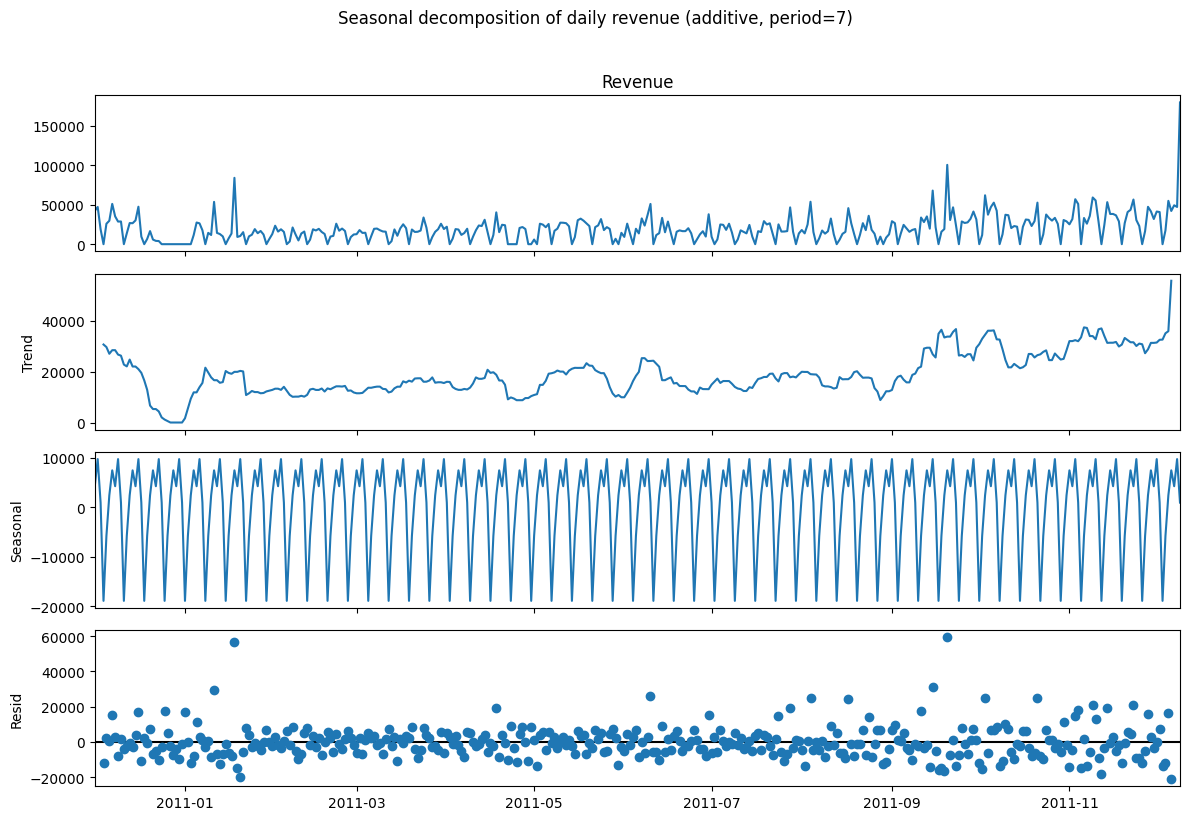

In [19]:
# Time series decomposition
# Ensure a continuous daily series
from statsmodels.tsa.seasonal import seasonal_decompose

# Seasonal decomposition
decomp = seasonal_decompose(daily_rev, model='additive', period=7)

fig = decomp.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Seasonal decomposition of daily revenue (additive, period=7)', y=1.02)
plt.tight_layout()
plt.show()

# Decomp_30 = seasonal_decompose
# Decomp_30.plot
# Plt.show


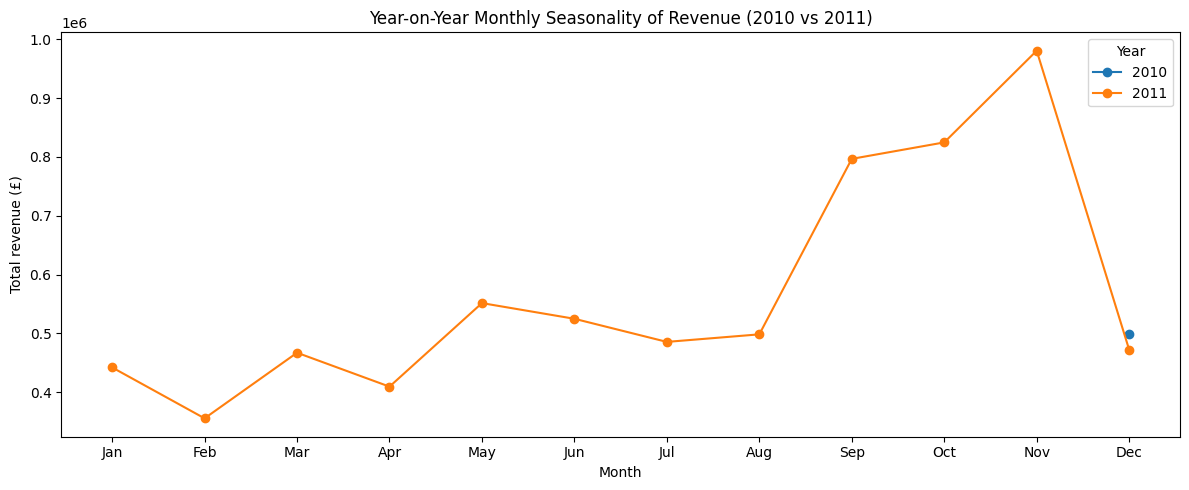

In [20]:
# Yoy seasonality plot
df_yoy = df.copy()
df_yoy = df_yoy.set_index("InvoiceDate").sort_index()

df_yoy["Year"] = df_yoy.index.year
df_yoy["Month"] = df_yoy.index.month_name().str[:3]  # Month abbreviation
df_yoy["MonthNum"] = df_yoy.index.month

# Monthly total revenue
monthly = (
    df_yoy
    .groupby(["Year", "MonthNum", "Month"])["TotalPrice"]
    .sum()
    .reset_index()
)

# Pivot to Month
yoy = monthly.pivot(index="Month", columns="Year", values="TotalPrice")

# Ensure months are in calendar order
month_order = (
    monthly[["MonthNum", "Month"]]
    .drop_duplicates()
    .sort_values("MonthNum")
)["Month"]
yoy = yoy.reindex(month_order)

# Plot year-on-year seasonality
plt.figure(figsize=(12, 5))
for year in yoy.columns:
    plt.plot(yoy.index, yoy[year], marker="o", label=str(year))

plt.title("Year-on-Year Monthly Seasonality of Revenue (2010 vs 2011)")
plt.xlabel("Month")
plt.ylabel("Total revenue (£)")
plt.legend(title="Year")
plt.tight_layout()
plt.show()

Top anomalous spike days (z-score > 3):


InvoiceDate
2011-12-09    179562.78
2011-09-20    100475.23
2011-01-18     84038.34
Name: Revenue, dtype: float64

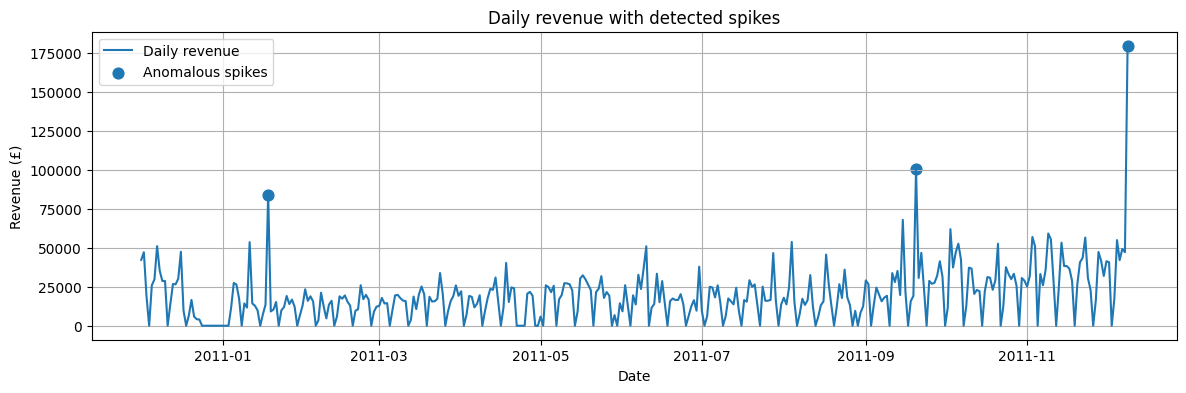

In [21]:
# Visualising outlier detection
# Z-score for anomaly detection
rev_mean = daily_rev.mean()
rev_std  = daily_rev.std()

z_scores = (daily_rev - rev_mean) / rev_std

# Choose a threshold, e.g. > 3 standard deviations
spikes = daily_rev[z_scores > 3]

print("Top anomalous spike days (z-score > 3):")
display(spikes.sort_values(ascending=False))

# Quick visual showing spikes
plt.figure(figsize=(14, 4))
plt.plot(daily_rev.index, daily_rev.values, label='Daily revenue')
plt.scatter(spikes.index, spikes.values, marker='o', s=60, label='Anomalous spikes')
plt.title('Daily revenue with detected spikes')
plt.xlabel('Date')
plt.ylabel('Revenue (£)')
plt.legend()
plt.grid(True)
plt.show()


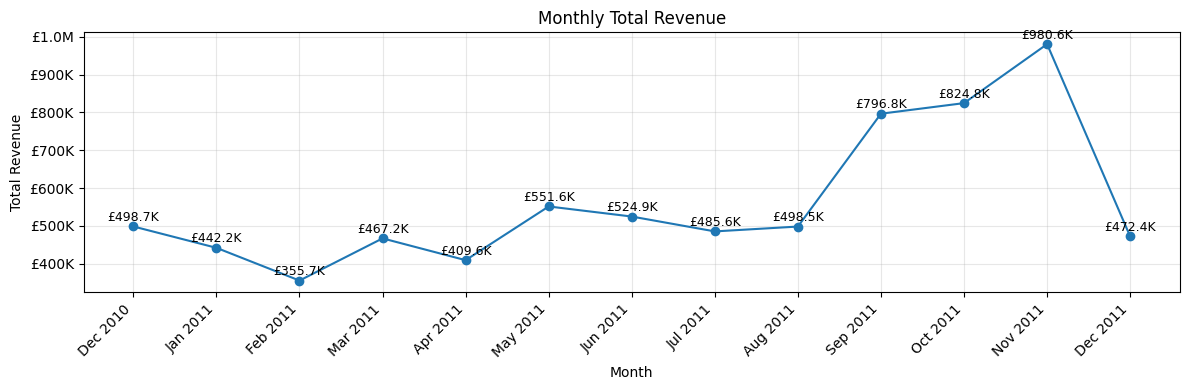

In [41]:
from matplotlib.ticker import FuncFormatter

# ================================
# Monthly Total Revenue (£K / £M Axis)
# ================================

monthly_revenue = (
    daily_rev
    .groupby(pd.Grouper(freq="M"))
    .sum()
)

monthly_revenue.index = monthly_revenue.index.strftime("%b %Y")

def pounds_formatter(x, pos):
    if x >= 1_000_000:
        return f"£{x/1_000_000:.1f}M"
    elif x >= 1_000:
        return f"£{x/1_000:.0f}K"
    else:
        return f"£{x:.0f}"

plt.figure(figsize=(12,4))
plt.plot(monthly_revenue.index, monthly_revenue.values, marker="o")

plt.title("Monthly Total Revenue")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45, ha="right")
plt.grid(alpha=0.3)

# Format y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(pounds_formatter))

# Point labels
for i, value in enumerate(monthly_revenue.values):
    plt.text(i, value + monthly_revenue.max()*0.015,
             f"£{value/1000:,.1f}K", ha="center", fontsize=9)

plt.tight_layout()
plt.show()


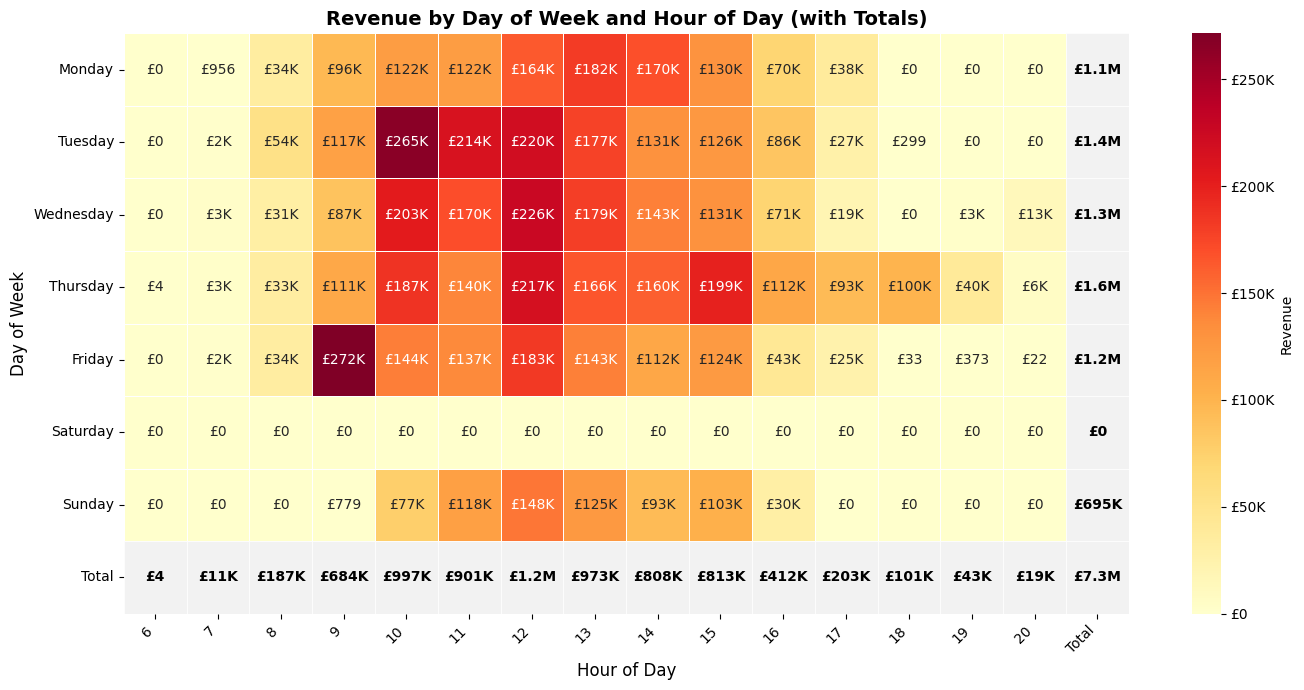

In [43]:
# --- Revenue heatmap by Day of Week x Hour of Day (with Totals) ---
# Uses your notebook's `df` (with datetime column `InvoiceDate` and revenue column `TotalPrice`)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter

# ----------------------------
# Helper: £ formatting (auto £K / £M)
# ----------------------------
def pounds_formatter(x, pos=None):
    if pd.isna(x):
        return ""
    x = float(x)
    if abs(x) >= 1_000_000:
        return f"£{x/1_000_000:.1f}M"
    if abs(x) >= 1_000:
        return f"£{x/1_000:.0f}K"
    return f"£{x:,.0f}"

# ----------------------------
# Weekday order
# ----------------------------
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

# ----------------------------
# Build revenue pivot (Weekday x Hour)
# ----------------------------
revenue_by_day_hour = (
    df.assign(
        Weekday=df["InvoiceDate"].dt.day_name(),
        Hour=df["InvoiceDate"].dt.hour
    )
    .groupby(["Weekday", "Hour"])["TotalPrice"]
    .sum()
    .reset_index(name="Revenue")
)

revenue_pivot = (
    revenue_by_day_hour
    .pivot(index="Weekday", columns="Hour", values="Revenue")
    .reindex(weekday_order)
    .fillna(0)
)

# Totals
row_totals = revenue_pivot.sum(axis=1)
col_totals = revenue_pivot.sum(axis=0)
grand_total = row_totals.sum()

# Annotations for main heatmap cells
annot_main = revenue_pivot.applymap(pounds_formatter)

# ----------------------------
# Plot heatmap (Yellow -> Red) + totals row/col
# ----------------------------
plt.figure(figsize=(14, 7))
ax = plt.gca()

vmin = 0
vmax = revenue_pivot.to_numpy().max()

sns.heatmap(
    revenue_pivot,
    cmap="YlOrRd",          # ✅ yellow -> orange -> red
    annot=annot_main,
    fmt="",
    linewidths=0.5,
    linecolor="white",
    vmin=vmin,
    vmax=vmax,
    cbar_kws={"label": "Revenue"},
    ax=ax
)

# Format colorbar ticks as £K/£M
cbar = ax.collections[0].colorbar
cbar.formatter = FuncFormatter(pounds_formatter)
cbar.update_ticks()

n_rows, n_cols = revenue_pivot.shape

# Expand axes for totals cells (right + bottom + bottom-right)
ax.set_xlim(0, n_cols + 1)
ax.set_ylim(n_rows + 1, 0)

# Tick labels incl. Total
xticks = np.arange(n_cols + 1) + 0.5
xticklabels = list(revenue_pivot.columns.astype(str)) + ["Total"]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=45, ha="right")

yticks = np.arange(n_rows + 1) + 0.5
yticklabels = list(revenue_pivot.index) + ["Total"]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, rotation=0)

# Draw totals cells (light grey)
total_facecolor = "#f2f2f2"
edgecolor = "white"
lw = 0.5

# Row totals (right-most column)
for y in range(n_rows):
    ax.add_patch(Rectangle((n_cols, y), 1, 1, facecolor=total_facecolor,
                           edgecolor=edgecolor, linewidth=lw, zorder=2))

# Column totals (bottom row)
for x in range(n_cols):
    ax.add_patch(Rectangle((x, n_rows), 1, 1, facecolor=total_facecolor,
                           edgecolor=edgecolor, linewidth=lw, zorder=2))

# Grand total (bottom-right)
ax.add_patch(Rectangle((n_cols, n_rows), 1, 1, facecolor=total_facecolor,
                       edgecolor=edgecolor, linewidth=lw, zorder=2))

# Annotate totals
for y, total in enumerate(row_totals):
    ax.text(n_cols + 0.5, y + 0.5, pounds_formatter(total),
            va="center", ha="center", fontsize=10, fontweight="bold", zorder=3)

for x, total in enumerate(col_totals):
    ax.text(x + 0.5, n_rows + 0.5, pounds_formatter(total),
            va="center", ha="center", fontsize=10, fontweight="bold", zorder=3)

ax.text(n_cols + 0.5, n_rows + 0.5, pounds_formatter(grand_total),
        va="center", ha="center", fontsize=10, fontweight="bold", zorder=3)

# Titles / labels
plt.title("Revenue by Day of Week and Hour of Day (with Totals)", fontsize=14, weight="bold")
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Day of Week", fontsize=12)
plt.tight_layout()
plt.show()


In [44]:
#top 10 highest selling items
rev_col = "Revenue" if "Revenue" in df.columns else "TotalPrice"

top_items = (
    df
    .groupby(["StockCode", "Description"], dropna=False)
    .agg(
        Revenue=(rev_col, "sum"),
        Quantity=("Quantity", "sum"),
        Transactions=("InvoiceNo", "count"),  
    )
    .reset_index()
    .sort_values(by="Revenue", ascending=False)
    .head(10)
)

# Format revenue for presentation
top_items["Revenue"] = top_items["Revenue"].apply(lambda x: f"£{x:,.2f}")

top_items

,StockCode,Description,Revenue,Quantity,Transactions
2587,23843,"PAPER CRAFT , LITTLE BIRDIE","£168,469.60",80995,1
1312,22423,REGENCY CAKESTAND 3 TIER,"£110,990.20",9641,1426
3442,85123A,WHITE HANGING HEART T-LIGHT HOLDER,"£94,858.60",34648,1940
2089,23166,MEDIUM CERAMIC TOP STORAGE JAR,"£80,291.44",76919,176
3427,85099B,JUMBO BAG RED RETROSPOT,"£77,371.57",41981,1464
2784,47566,PARTY BUNTING,"£63,109.38",13992,1307
3262,84879,ASSORTED COLOUR BIRD ORNAMENT,"£52,395.99",32727,1333
2945,79321,CHILLI LIGHTS,"£45,505.31",9498,513
998,22086,PAPER CHAIN KIT 50'S CHRISTMAS,"£40,451.08",14792,982
1387,22502,PICNIC BASKET WICKER 60 PIECES,"£39,619.50",61,2


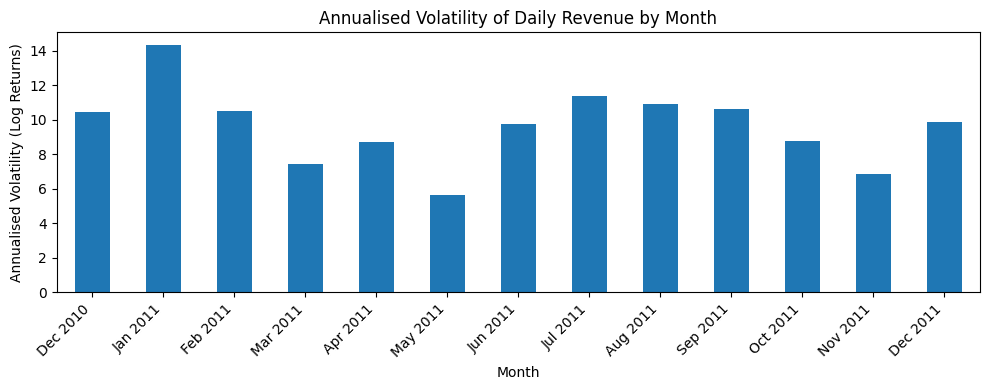

In [37]:
# ================================
# Annualised volatility of revenue
# ================================

# Prepare daily log returns (ignore zero-revenue days)
rev_for_returns = daily_rev.replace(0, np.nan)
log_rev = np.log(rev_for_returns)
daily_log_returns = log_rev.diff().dropna()

# Monthly annualised volatility
monthly_vol = (
    daily_log_returns
    .groupby(pd.Grouper(freq="M"))
    .std() * np.sqrt(252)
)

# Drop months with too few observations
min_obs_per_month = 5
obs_per_month = daily_log_returns.groupby(pd.Grouper(freq="M")).count()
monthly_vol[obs_per_month < min_obs_per_month] = np.nan

# Convert index to clean Month-Year labels
monthly_vol.index = monthly_vol.index.strftime("%b %Y")

# ================================
# Plot
# ================================
plt.figure(figsize=(10, 4))
monthly_vol.plot(kind="bar")
plt.title("Annualised Volatility of Daily Revenue by Month")
plt.xlabel("Month")
plt.ylabel("Annualised Volatility (Log Returns)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## 8. Exploratory analysis of engineered customer features

Sanity checks, summary statistics, and visual exploration of engineered features before clustering / modelling.

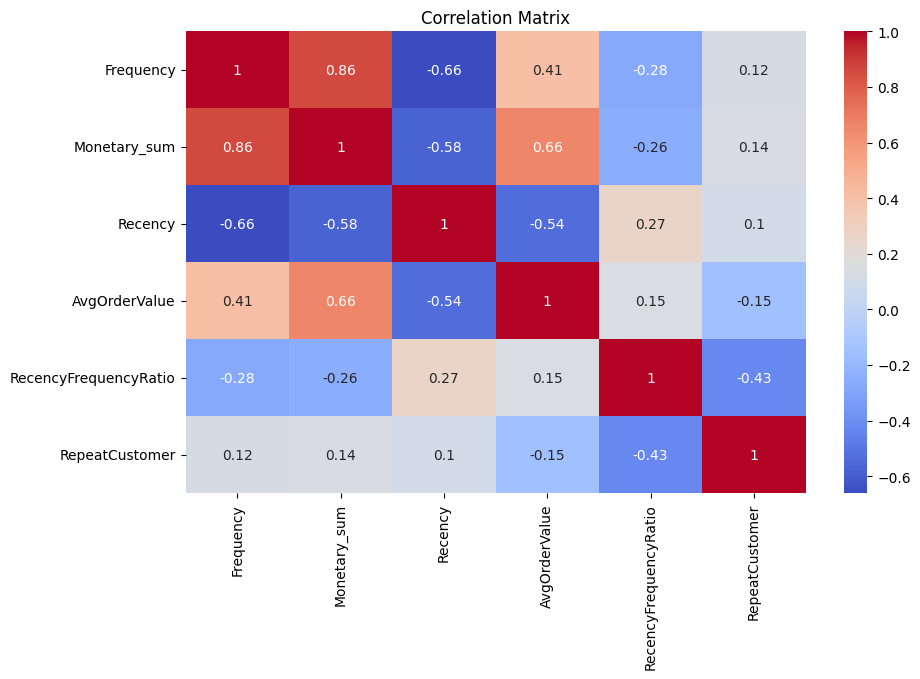

In [23]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(
    cust_features[["Frequency","Monetary_sum","Recency","AvgOrderValue","RecencyFrequencyRatio","RepeatCustomer"]].corr(),
    annot=True,
    cmap="coolwarm"
)
plt.title("Correlation Matrix")
plt.show()


In [24]:
# Summary stats
cust_features[["Frequency", "Monetary_sum", "Monetary_avg", "Recency"]].describe().T


,count,mean,std,min,25%,50%,75%,max
Frequency,3920.0,2.268112,2.492408,0.0,1.0000,1.000000,3.00000,9.000000
Monetary_sum,3920.0,748.212563,995.691495,0.0,83.1475,334.215000,948.33250,3718.231000
Monetary_avg,3920.0,236.873812,206.041579,0.0,70.4175,203.193333,347.61375,740.576731
Recency,3920.0,136.987755,105.639082,0.0,37.0000,112.500000,275.00000,283.000000


In [25]:
cust_features[["Frequency", "Monetary_sum", "Monetary_avg", "Recency"]].skew()

Frequency       1.462419
Monetary_sum    1.793415
Monetary_avg    0.816094
Recency         0.265787
dtype: float64

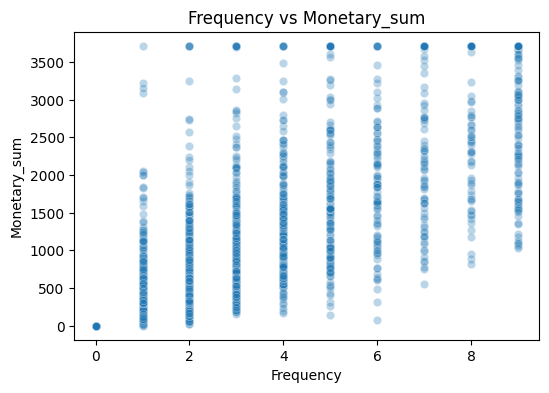

,Frequency,Monetary_sum,Monetary_avg,Recency,RepeatCustomer
Frequency,1.000000,0.859923,0.406717,-0.662012,0.120167
Monetary_sum,0.859923,1.000000,0.659179,-0.575185,0.137475
Monetary_avg,0.406717,0.659179,1.000000,-0.538258,-0.153567
Recency,-0.662012,-0.575185,-0.538258,1.000000,0.103331
RepeatCustomer,0.120167,0.137475,-0.153567,0.103331,1.000000


In [26]:
# Intra-variable relationships plotted
# Scatter: Monetary vs Frequency
plt.figure(figsize=(6, 4))
sns.scatterplot(x="Frequency", y="Monetary_sum", data=cust_features, alpha=0.3)
plt.title("Frequency vs Monetary_sum")
plt.show()

# Pearson correlations
cust_features[["Frequency", "Monetary_sum", "Monetary_avg", "Recency", "RepeatCustomer"]].corr()


## 9. Clustering

Segment customers using K-Means on key behavioural variables and profile cluster behaviour.

In [27]:
# K-means clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

cluster_vars = ["Recency", "Frequency", "Monetary_sum"]
X_cluster = cust_features[cluster_vars].copy()

scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

# Elbow and silhouette
sil_scores = {}
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    labels = km.fit_predict(X_cluster_scaled)
    sil_scores[k] = silhouette_score(X_cluster_scaled, labels)

sil_scores  # Inspect this to pick k

# Choose best k
best_k = max(sil_scores, key=sil_scores.get)
kmeans_final = KMeans(n_clusters=best_k, random_state=RANDOM_STATE)
cust_features["Cluster"] = kmeans_final.fit_predict(X_cluster_scaled)

# Profile clusters
cust_features.groupby("Cluster")[cluster_vars + ["RepeatCustomer"]].mean()


,Recency,Frequency,Monetary_sum,RepeatCustomer
Cluster,,,,
0,28.905498,7.151203,2757.085132,0.895189
1,255.739216,0.473856,123.029203,0.728758
2,71.287611,2.214602,630.605653,0.540376


In [28]:
# Share of customers per cluster
cluster_counts = cust_features["Cluster"].value_counts().sort_index()
cluster_pct_customers = cluster_counts / len(cust_features) * 100

# Share of revenue
revenue_by_cluster = cust_features.groupby("Cluster")["Monetary_sum"].sum()
total_revenue = revenue_by_cluster.sum()
cluster_pct_revenue = revenue_by_cluster / total_revenue * 100

# Combine into a single summary table
cluster_summary = pd.DataFrame({
    "Number of Customers": cluster_counts,
    "% of Total customers": cluster_pct_customers.round(2),
    "Revenue": revenue_by_cluster.round(2),
    "% of Total Revenue": cluster_pct_revenue.round(2)
})

cluster_summary

,Number of Customers,% of Total customers,Revenue,% of Total Revenue
Cluster,,,,
0,582,14.85,1604623.55,54.71
1,1530,39.03,188234.68,6.42
2,1808,46.12,1140135.02,38.87


Text(0.5, 1.0, 'Silhouette Score vs k')

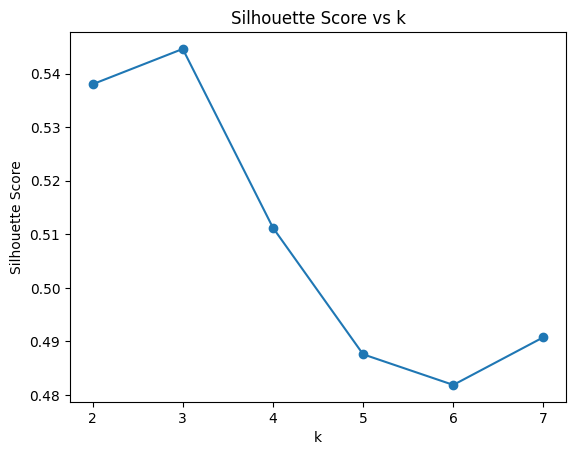

In [29]:
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs k")

## 10. Modelling and evaluation

Train and compare classification pipelines (including leakage-safe clustering transformer) and review performance metrics.

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support

set_config(transform_output="pandas")

# 1) Cluster transformer that fits ONLY on training folds
from sklearn.cluster import KMeans

class KMeansClusterAdder(BaseEstimator, TransformerMixin):
    def __init__(self, cluster_vars, n_clusters=4, random_state=42):
        self.cluster_vars = cluster_vars
        self.n_clusters = n_clusters
        self.random_state = random_state

    def fit(self, X, y=None):
        Xc = X[self.cluster_vars].copy()
        self.scaler_ = StandardScaler()
        Xs = self.scaler_.fit_transform(Xc)
        self.kmeans_ = KMeans(
            n_clusters=self.n_clusters,
            random_state=self.random_state,
            n_init="auto"
        )
        self.kmeans_.fit(Xs)
        return self

    def transform(self, X):
        X_out = X.copy()
        Xc = X_out[self.cluster_vars].copy()
        Xs = self.scaler_.transform(Xc)
        X_out["Cluster"] = self.kmeans_.predict(Xs)
        return X_out


# 2) Features / target
BASE_FEATURES = [
    "Recency", "Frequency", "Monetary_sum", "Monetary_avg",
    "AvgOrderValue", "RecencyFrequencyRatio",
    "MeanGap", "StdGap", "BasketCV", "SpendTrend"
]
TARGET = "RepeatCustomer"
CLUSTER_VARS = ["Recency", "Frequency", "Monetary_sum"]

X = cust_features[BASE_FEATURES].copy()
y = cust_features[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

# Version-safe OneHotEncoder dense output
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_features = BASE_FEATURES

prep_scaled_no_cluster = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

prep_unscaled_no_cluster = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median"))
        ]), numeric_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


# 3) Model pipelines
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# XGBoost
try:
    from xgboost import XGBClassifier
    _HAS_XGB = True
except Exception:
    _HAS_XGB = False



pipelines = {
    "LogReg": Pipeline([
        ("prep", prep_scaled_no_cluster),
        ("model", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
    ]),
    "DecisionTree": Pipeline([
        ("prep", prep_unscaled_no_cluster),
        ("model", DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]),
    "RandomForest": Pipeline([
        ("prep", prep_unscaled_no_cluster),
        ("model", RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1))
    ]),
    "KNN": Pipeline([
        ("prep", prep_scaled_no_cluster),
        ("model", KNeighborsClassifier())
    ]),
    "HistGB": Pipeline([
        ("prep", prep_unscaled_no_cluster),
        ("model", HistGradientBoostingClassifier(random_state=RANDOM_STATE))
    ]),
}

if _HAS_XGB:
    pipelines["XGBoost"] = Pipeline([
        ("prep", prep_unscaled_no_cluster),
        ("model", XGBClassifier(
            random_state=RANDOM_STATE,
            eval_metric="logloss",
            n_jobs=-1
        ))
    ])


# 4) Hyperparameter grids
param_grids = {
    "LogReg": {
        "model__C": [0.1, 0.5, 1, 2, 5],
        "model__class_weight": [None, "balanced"]
    },
    "DecisionTree": {
        "model__max_depth": [None, 3, 5, 8, 12],
        "model__min_samples_split": [2, 5, 10, 20],
        "model__min_samples_leaf": [1, 2, 5, 10],
        "model__class_weight": [None, "balanced"]
    },
    "RandomForest": {
        "model__n_estimators": [300, 500],
        "model__max_depth": [None, 6, 10, 16],
        "model__min_samples_split": [2, 5, 10],
        "model__class_weight": [None, "balanced"]
    },
    "KNN": {
        "model__n_neighbors": [5, 11, 21, 31],
        "model__weights": ["uniform", "distance"]
    },
    "HistGB": {
        "model__learning_rate": [0.03, 0.06, 0.1],
        "model__max_depth": [None, 3, 5, 7],
        "model__max_leaf_nodes": [15, 31, 63]
    },
}

if _HAS_XGB:
    param_grids["XGBoost"] = {
        "model__n_estimators": [300, 600],
        "model__max_depth": [3, 5, 7],
        "model__learning_rate": [0.03, 0.06, 0.1],
        "model__subsample": [0.8, 1.0],
        "model__colsample_bytree": [0.8, 1.0],
        "model__reg_lambda": [1.0, 2.0, 5.0],
    }


def metrics_summary(name, y_true, y_pred, y_proba):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    auc = roc_auc_score(y_true, y_proba)
    return {"Model": name, "Precision": precision, "Recall": recall, "F1": f1, "ROC_AUC": auc}


results = []
best_models = {}

for name, pipe in pipelines.items():
    print(f"\n=== Tuning: {name} ===")

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        scoring="f1",
        cv=cv,
        n_jobs=-1
    )
    gs.fit(X_train, y_train)

    best_models[name] = gs.best_estimator_
    print("Best params:", gs.best_params_)
    print("Best CV F1:", gs.best_score_)

    # Holdout evaluation
    y_pred = gs.best_estimator_.predict(X_test)

    # Probability handling
    if hasattr(gs.best_estimator_, "predict_proba"):
        y_proba = gs.best_estimator_.predict_proba(X_test)[:, 1]
    else:
        # Fallback: use decision_function if present
        scores = gs.best_estimator_.decision_function(X_test)
        # Min-max to
        y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)

    results.append(metrics_summary(name, y_test, y_pred, y_proba))

results_df = pd.DataFrame(results).sort_values(by="F1", ascending=False)
results_df



=== Tuning: LogReg ===
Best params: {'model__C': 0.1, 'model__class_weight': None}
Best CV F1: 0.8035629363818645

=== Tuning: DecisionTree ===
Best params: {'model__class_weight': None, 'model__max_depth': 3, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Best CV F1: 0.7988032253326415

=== Tuning: RandomForest ===
Best params: {'model__class_weight': None, 'model__max_depth': 6, 'model__min_samples_split': 5, 'model__n_estimators': 300}
Best CV F1: 0.8039883118342548

=== Tuning: KNN ===
Best params: {'model__n_neighbors': 11, 'model__weights': 'distance'}
Best CV F1: 0.7999022867532313

=== Tuning: HistGB ===
Best params: {'model__learning_rate': 0.03, 'model__max_depth': 3, 'model__max_leaf_nodes': 15}
Best CV F1: 0.8061946586242044

=== Tuning: XGBoost ===
Best params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.03, 'model__max_depth': 3, 'model__n_estimators': 300, 'model__reg_lambda': 5.0, 'model__subsample': 0.8}
Best CV F1: 0.8055473918232632


,Model,Precision,Recall,F1,ROC_AUC
4,HistGB,0.831620,0.825255,0.828425,0.837662
5,XGBoost,0.817150,0.826531,0.821814,0.835423
2,RandomForest,0.826031,0.817602,0.821795,0.837724
0,LogReg,0.786885,0.857143,0.820513,0.833491
1,DecisionTree,0.813602,0.823980,0.818758,0.821396
3,KNN,0.788835,0.829082,0.808458,0.808594


# 11. Visualisations for analysis findings

In [31]:
results_df = pd.DataFrame(results).sort_values(by="F1", ascending=False)
results_df
metrics = ['Precision', 'Recall', 'F1', 'ROC_AUC']
styled_results = (
    results_df
    .style
    .highlight_max(subset=metrics, axis=0, props='background-color: #4CAF50')
    .highlight_min(subset=metrics, axis=0, props='background-color: blue')
    .format({col: "{:.3f}" for col in metrics})
)

display(styled_results)

,Model,Precision,Recall,F1,ROC_AUC
4,HistGB,0.832,0.825,0.828,0.838
5,XGBoost,0.817,0.827,0.822,0.835
2,RandomForest,0.826,0.818,0.822,0.838
0,LogReg,0.787,0.857,0.821,0.833
1,DecisionTree,0.814,0.824,0.819,0.821
3,KNN,0.789,0.829,0.808,0.809


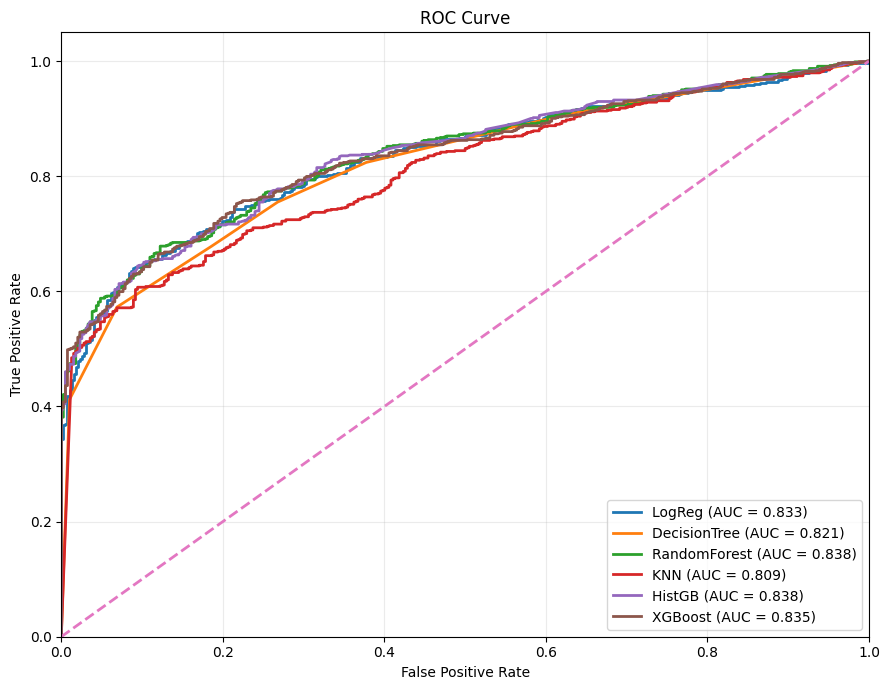

In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC curves
plt.figure(figsize=(9, 7))

for name, est in best_models.items():
    # Get probabilities
    if hasattr(est, "predict_proba"):
        y_score = est.predict_proba(X_test)[:, 1]
    elif hasattr(est, "decision_function"):
        scores = est.decision_function(X_test)
        y_score = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)
    else:
        # Last resort: treat predictions as scores
        y_score = est.predict(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

# Diagonal baseline
plt.plot([0, 1], [0, 1], linestyle="--", lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()


In [33]:
from sklearn.metrics import confusion_matrix
import numpy as np

print("\n================= CONFUSION MATRICES (Test Set) =================\n")

for name, est in best_models.items():
    y_pred = est.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    tn, fp, fn, tp = cm.ravel()

    print(f"=== {name} ===")
    print("Confusion Matrix:")
    print(np.array([[tn, fp],
                    [fn, tp]]))
    print(f"TN = {tn} | FP = {fp}")
    print(f"FN = {fn} | TP = {tp}")
    print("-" * 45, "\n")



================= CONFUSION MATRICES (Test Set) =================

=== LogReg ===
Confusion Matrix:
[[210 182]
 [112 672]]
TN = 210 | FP = 182
FN = 112 | TP = 672
--------------------------------------------- 

=== DecisionTree ===
Confusion Matrix:
[[244 148]
 [138 646]]
TN = 244 | FP = 148
FN = 138 | TP = 646
--------------------------------------------- 

=== RandomForest ===
Confusion Matrix:
[[257 135]
 [143 641]]
TN = 257 | FP = 135
FN = 143 | TP = 641
--------------------------------------------- 

=== KNN ===
Confusion Matrix:
[[218 174]
 [134 650]]
TN = 218 | FP = 174
FN = 134 | TP = 650
--------------------------------------------- 

=== HistGB ===
Confusion Matrix:
[[261 131]
 [137 647]]
TN = 261 | FP = 131
FN = 137 | TP = 647
--------------------------------------------- 

=== XGBoost ===
Confusion Matrix:
[[247 145]
 [136 648]]
TN = 247 | FP = 145
FN = 136 | TP = 648
--------------------------------------------- 



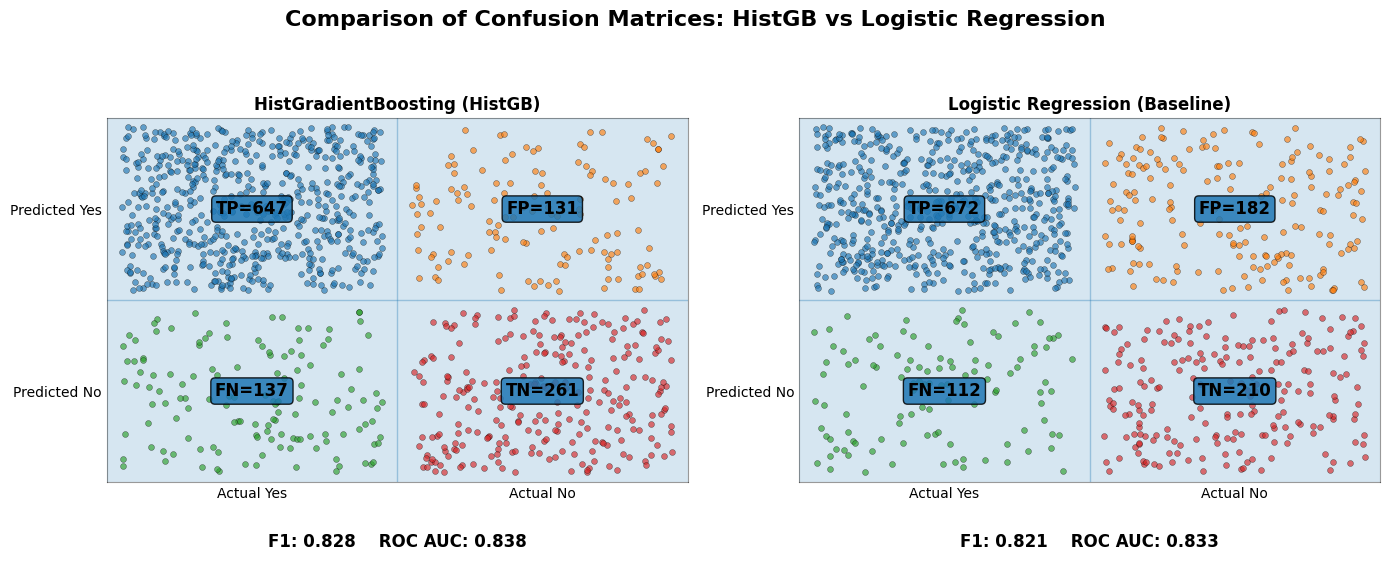

HistGB  ->  F1: 0.828  | ROC AUC: 0.838  | Confusion Matrix:
 [[261 131]
 [137 647]] 

LogReg  ->  F1: 0.821  | ROC AUC: 0.833  | Confusion Matrix:
 [[210 182]
 [112 672]]


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score

def _get_proba_or_score(est, X):
    if hasattr(est, "predict_proba"):
        return est.predict_proba(X)[:, 1]
    if hasattr(est, "decision_function"):
        s = est.decision_function(X)
        return (s - s.min()) / (s.max() - s.min() + 1e-12)
    return est.predict(X)

def _confusion_viz(ax, cm, title, seed=0):
    """
    Visualize a 2x2 confusion matrix with jittered points.

    Parameters
    ----------
    cm : array-like of shape (2, 2)
        Output of sklearn.metrics.confusion_matrix: [[tn, fp], [fn, tp]].
    """

    tn, fp, fn, tp = cm.ravel()

    # Background quadrants
    ax.set_xlim(0, 2); ax.set_ylim(0, 2)
    ax.add_patch(plt.Rectangle((0, 1), 1, 1, alpha=0.18))  # TP
    ax.add_patch(plt.Rectangle((1, 1), 1, 1, alpha=0.18))  # FP
    ax.add_patch(plt.Rectangle((0, 0), 1, 1, alpha=0.18))  # FN
    ax.add_patch(plt.Rectangle((1, 0), 1, 1, alpha=0.18))  # TN

    # Jittered dots to mimic the look
    rng = np.random.default_rng(seed)
    def scatter_box(x0, y0, w, h, n):
        n = int(min(n, 600))  # Cap points so plots stay fast/clean
        xs = x0 + rng.random(n) * w
        ys = y0 + rng.random(n) * h
        ax.scatter(xs, ys, s=18, alpha=0.65, edgecolors="k", linewidths=0.3)

    # Plot points per quadrant
    scatter_box(0.05, 1.05, 0.9, 0.9, tp)  # TP
    scatter_box(1.05, 1.05, 0.9, 0.9, fp)  # FP
    scatter_box(0.05, 0.05, 0.9, 0.9, fn)  # FN
    scatter_box(1.05, 0.05, 0.9, 0.9, tn)  # TN

    # Labels
    ax.text(0.5, 1.5, f"TP={tp}", ha="center", va="center",
            fontsize=12, weight="bold", bbox=dict(boxstyle="round,pad=0.25", alpha=0.85))
    ax.text(1.5, 1.5, f"FP={fp}", ha="center", va="center",
            fontsize=12, weight="bold", bbox=dict(boxstyle="round,pad=0.25", alpha=0.85))
    ax.text(0.5, 0.5, f"FN={fn}", ha="center", va="center",
            fontsize=12, weight="bold", bbox=dict(boxstyle="round,pad=0.25", alpha=0.85))
    ax.text(1.5, 0.5, f"TN={tn}", ha="center", va="center",
            fontsize=12, weight="bold", bbox=dict(boxstyle="round,pad=0.25", alpha=0.85))

    # Label axes
    ax.set_xticks([0.5, 1.5], labels=["Actual Yes", "Actual No"])
    ax.set_yticks([1.5, 0.5], labels=["Predicted Yes", "Predicted No"])
    ax.tick_params(axis="both", length=0)
    ax.set_title(title, fontsize=12, weight="bold")
    ax.axvline(1, linewidth=1, alpha=0.35)
    ax.axhline(1, linewidth=1, alpha=0.35)
    for spine in ax.spines.values():
        spine.set_alpha(0.4)

# Pick the two models
histgb = best_models["HistGB"]
logreg = best_models["LogReg"]  

# Compute metrics on test set
def compute_metrics(name, est):
    y_pred = est.predict(X_test)
    y_score = _get_proba_or_score(est, X_test)
    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_score)
    return cm, f1, roc

cm_h, f1_h, roc_h = compute_metrics("HistGB", histgb)
cm_l, f1_l, roc_l = compute_metrics("LogReg", logreg)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Comparison of Confusion Matrices: HistGB vs Logistic Regression", fontsize=16, weight="bold")

_confusion_viz(axes[0], cm_h, "HistGradientBoosting (HistGB)", seed=1)
_confusion_viz(axes[1], cm_l, "Logistic Regression (Baseline)", seed=2)

# Metric text under each panel
axes[0].text(0.5, -0.14, f"F1: {f1_h:.3f}    ROC AUC: {roc_h:.3f}",
             transform=axes[0].transAxes, ha="center", va="top", fontsize=12, weight="bold")
axes[1].text(0.5, -0.14, f"F1: {f1_l:.3f}    ROC AUC: {roc_l:.3f}",
             transform=axes[1].transAxes, ha="center", va="top", fontsize=12, weight="bold")

plt.tight_layout(rect=[0, 0.03, 1, 0.92])
plt.show()

# Also print the metrics neatly
print("HistGB  ->  F1:", round(f1_h, 3), " | ROC AUC:", round(roc_h, 3), " | Confusion Matrix:\n", cm_h, "\n")
print("LogReg  ->  F1:", round(f1_l, 3), " | ROC AUC:", round(roc_l, 3), " | Confusion Matrix:\n", cm_l)


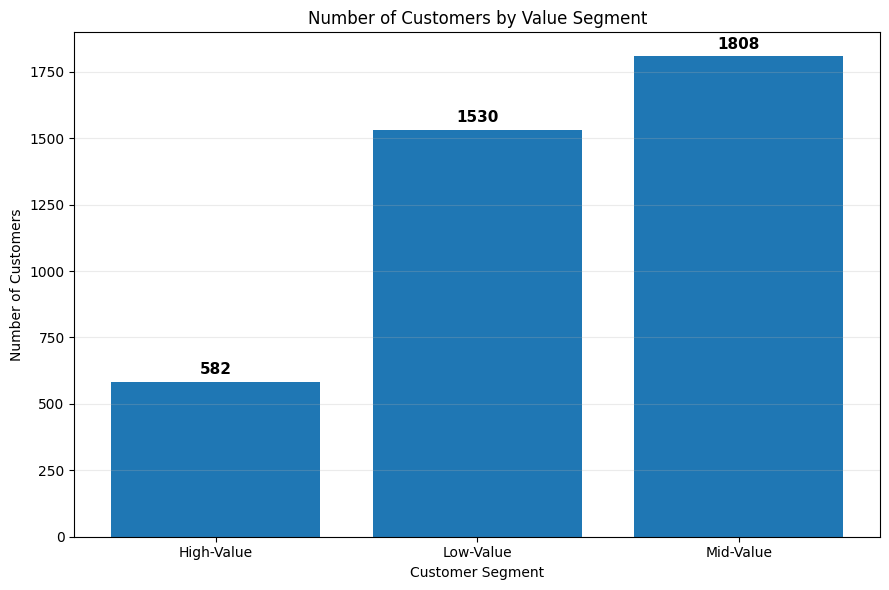

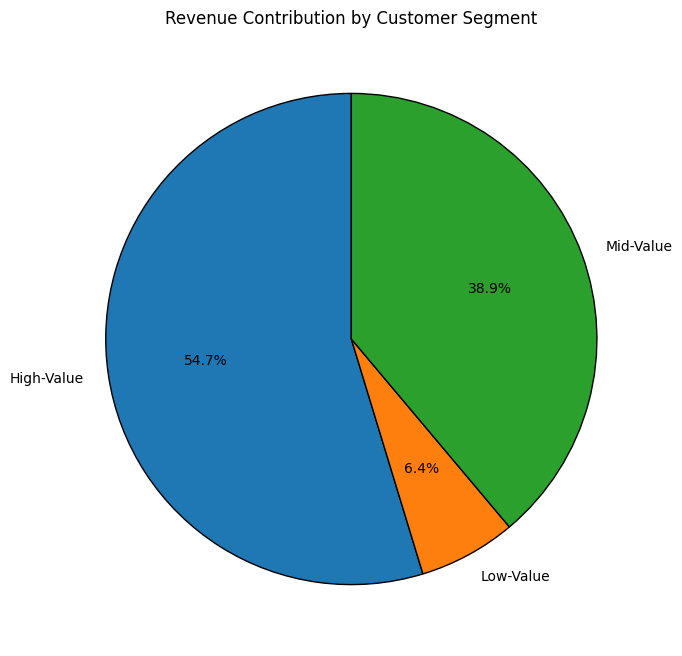

In [35]:
import matplotlib.pyplot as plt

# Cluster name mapping
cluster_names = {
    "0": "High-Value",
    "1": "Low-Value",
    "2": "Mid-Value"
}

clusters = cluster_summary.index.astype(str)
labels = [cluster_names[c] for c in clusters]
counts = cluster_summary["Number of Customers"]

# ---
# Bar Chart — Number of Customers
# ---
plt.figure(figsize=(9,6))
bars = plt.bar(labels, counts)

plt.title("Number of Customers by Value Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Number of Customers")
plt.grid(axis="y", alpha=0.25)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + max(counts)*0.01,
             f"{int(height)}",
             ha="center", va="bottom", fontsize=11, weight="bold")

plt.tight_layout()
plt.show()

# ---
# Pie Chart — Revenue Share
# ---
plt.figure(figsize=(7,7))

plt.pie(
    cluster_summary["% of Total Revenue"],
    labels=[cluster_names[c] for c in clusters],
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops={"edgecolor": "black", "linewidth": 1}
)

plt.title("Revenue Contribution by Customer Segment")
plt.tight_layout()
plt.show()


In [36]:
# Repeat rate per cluster
repeat_rate_table = (
    cust_features
    .groupby("Cluster")["RepeatCustomer"]
    .mean()
    .mul(100)
    .round(1)
    .rename("Repeat Rate (%)")
    .to_frame()
)

# Rename clusters to value segments
repeat_rate_table.index = repeat_rate_table.index.astype(str).map({
    "0": "High-Value",
    "1": "Low-Value",
    "2": "Mid-Value"
})

repeat_rate_table


,Repeat Rate (%)
Cluster,
High-Value,89.5
Low-Value,72.9
Mid-Value,54.0
